In [40]:
# Download the dataset silently
!wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

# Extract the dataset silently
!tar -xf VOCtrainval_06-Nov-2007.tar


In [41]:
import os
import glob
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# Define dataset paths
DATASET_ROOT = "VOCdevkit/VOC2007"
ANNOTATION_FOLDER = "Annotations"
IMAGES_FOLDER = "JPEGImages"
ANNOTATIONS_PATH = os.path.join(DATASET_ROOT, ANNOTATION_FOLDER)
IMAGES_PATH = os.path.join(DATASET_ROOT, IMAGES_FOLDER)

# Load image paths and annotations
image_files = sorted(glob.glob(os.path.join(IMAGES_PATH, "*.jpg")))
annotation_files = [os.path.join(ANNOTATIONS_PATH, os.path.basename(file).replace(".jpg", ".xml")) for file in image_files]

# Split the dataset
train_images, val_test_images, train_annotations, val_test_annotations = train_test_split(
    image_files, annotation_files, test_size=0.4, random_state=42
)
val_images, test_images, val_annotations, test_annotations = train_test_split(
    val_test_images, val_test_annotations, test_size=0.5, random_state=42
)

# Output sizes
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")


Training set size: 3006
Validation set size: 1002
Test set size: 1003


In [42]:

from collections import Counter

# Function to parse an XML annotation file and extract class names
def extract_classes_from_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    classes = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        classes.append(name)
    return classes

# Extract and count classes from all annotations
all_classes = []
for annotation_file in annotation_files:
    all_classes.extend(extract_classes_from_annotation(annotation_file))

class_counts = Counter(all_classes)

# Output class counts
print("Class counts:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Class counts:
chair: 1432
car: 1644
horse: 406
person: 5447
bicycle: 418
cat: 389
dog: 538
train: 328
aeroplane: 331
diningtable: 310
tvmonitor: 367
bird: 599
bottle: 634
motorbike: 390
pottedplant: 625
boat: 398
sofa: 425
sheep: 353
cow: 356
bus: 272


In [43]:
import xml.etree.ElementTree as ET

def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        objects.append({'name': name, 'bbox': [xmin, ymin, xmax, ymax]})
    return objects


In [44]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def load_image(image_path):
    return Image.open(image_path)


In [47]:
def draw_boxes(image, objects):
    """
    Draw bounding boxes and labels on an image and display it.

    Args:
        image (PIL.Image.Image): The image object on which to draw the boxes.
        objects (list of dict): A list of objects, each represented as a dictionary with keys 'bbox' and 'name'.
                                'bbox' should be a list or tuple with four values [x_min, y_min, x_max, y_max].
                                'name' should be a string representing the label of the object.
    """
    # Create a figure and axis for displaying the image
    fig, ax = plt.subplots(1, figsize=(12, 8))

    # Display the image on the axis
    ax.imshow(image)

    # Iterate over each object in the list
    for obj in objects:
        bbox = obj['bbox']# Extract the bounding box coordinates
        # Create a rectangle patch with the bounding box coordinates
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
        # Add the rectangle patch to the axis
        ax.add_patch(rect)
         # Add a text label at the top-left corner of the bounding box
        plt.text(bbox[0], bbox[1], obj['name'], color='red', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    # Hide the axis for a cleaner display
    plt.axis('off')
    # Show the image with bounding boxes and labels
    plt.show()


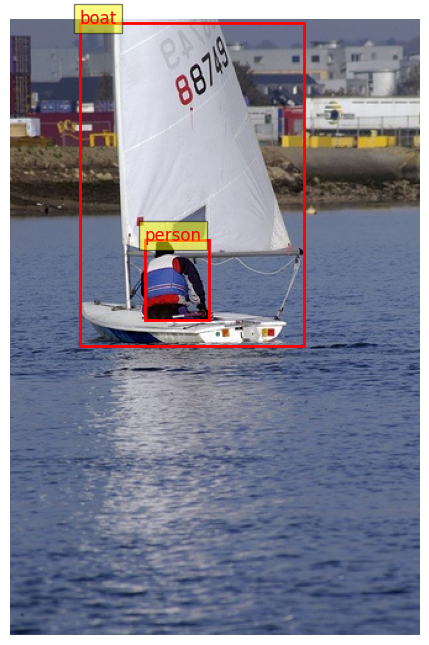

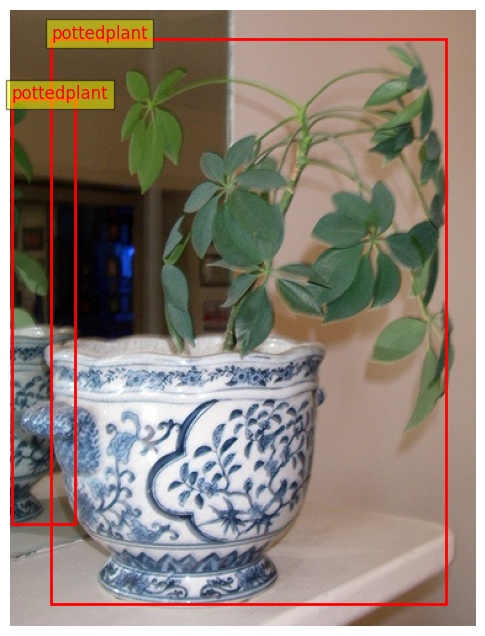

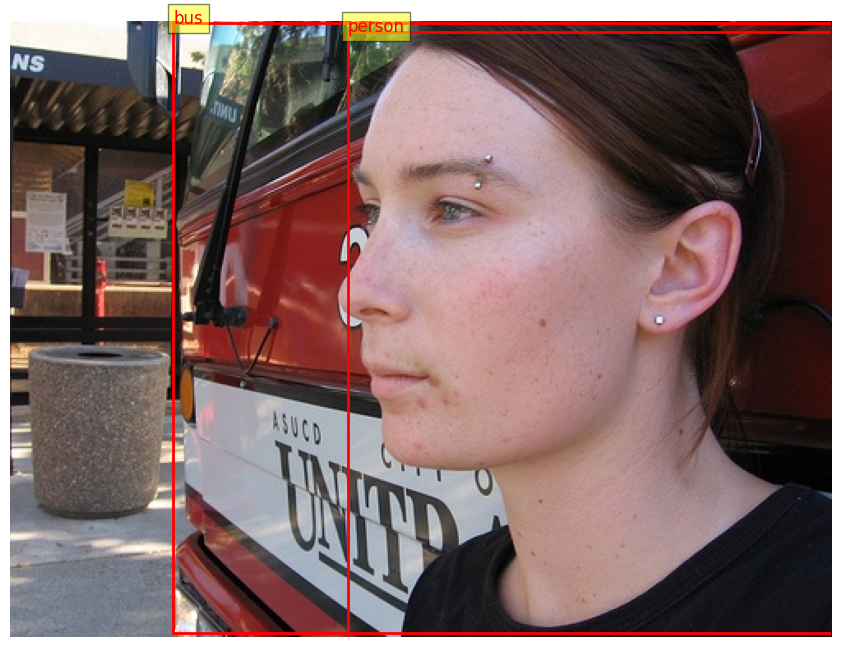

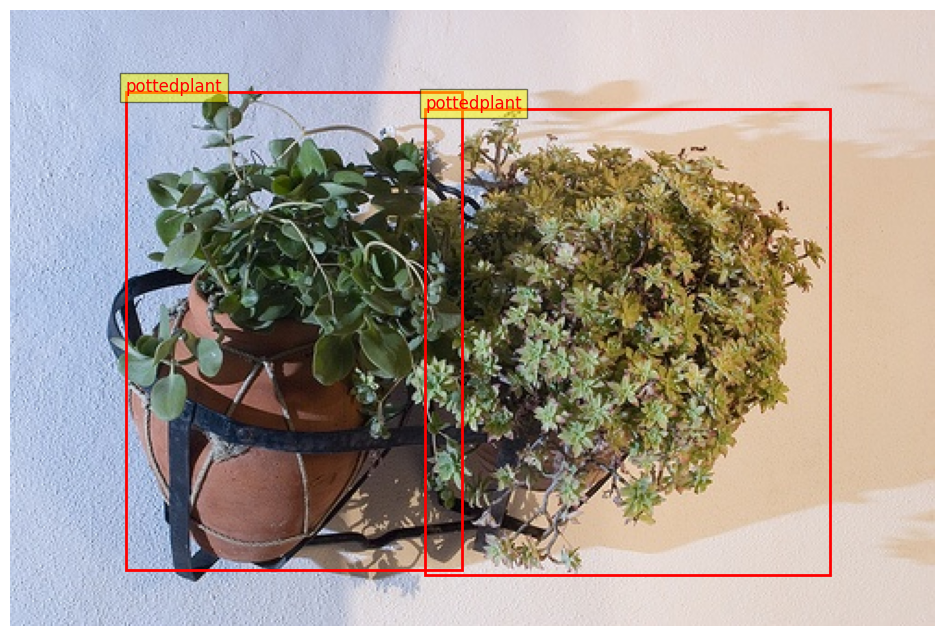

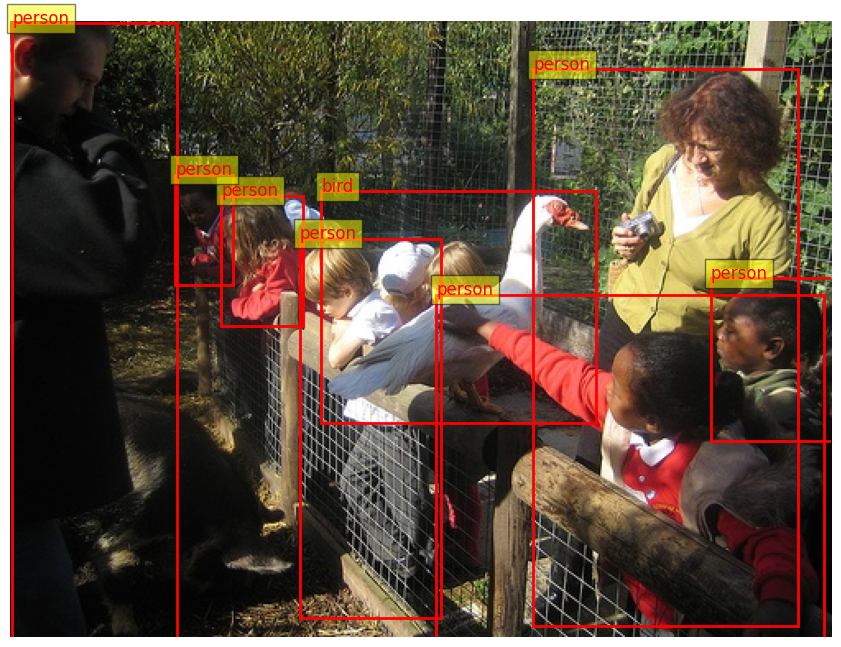

In [50]:
import random

def visualize_samples(image_files, annotation_files, num_samples=5):

      # Randomly select indices for the specified number of samples
      sample_indices = random.sample(range(len(image_files)), num_samples)

      # Iterate over each selected index
      for idx in sample_indices:
          image_path = image_files[idx]
          annotation_path = annotation_files[idx]

          image = load_image(image_path)
          objects = parse_annotation(annotation_path)

          draw_boxes(image, objects)

# Visualize sample images from the training set
visualize_samples(train_images, train_annotations, num_samples=5)


In [51]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

def preprocess_image(image_path, target_size=(640, 640)):
    """Preprocesses an image for the dataset."""
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

def convert_to_yolo_format(bbox, image_width, image_height):
    """Converts bounding box to YOLO format."""
    xmin, ymin, xmax, ymax = bbox
    x_center = (xmin + xmax) / 2.0 / image_width
    y_center = (ymin + ymax) / 2.0 / image_height
    width = (xmax - xmin) / image_width
    height = (ymax - ymin) / image_height
    return [x_center, y_center, width, height]

def parse_annotation(annotation_path):
    """Parses an XML annotation file."""
    try:
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            bbox_coords = [
                int(bbox.find('xmin').text),
                int(bbox.find('ymin').text),
                int(bbox.find('xmax').text),
                int(bbox.find('ymax').text)
            ]
            objects.append({'name': name, 'bbox': bbox_coords})
        return objects
    except ET.ParseError as e:
        print(f"Error parsing {annotation_path}: {e}")
        return []  # Return empty list if there's an error

def preprocess_annotations(annotation_path, image_width, image_height, class_mapping):
    """Preprocesses annotations for YOLO format."""
    objects = parse_annotation(annotation_path)
    yolo_annotations = []
    for obj in objects:
        if obj['name'] in class_mapping:  # Ensure class is in mapping
            class_id = class_mapping[obj['name']]
            bbox = obj['bbox']
            yolo_bbox = convert_to_yolo_format(bbox, image_width, image_height)
            yolo_annotations.append([class_id] + yolo_bbox)
    return yolo_annotations

def save_processed_data(image_files, annotation_files, output_image_dir, output_annotation_dir, class_mapping, target_size=(640, 640)):
    """Processes and saves images and annotations."""
    if not os.path.exists(output_image_dir):
        os.makedirs(output_image_dir)
    if not os.path.exists(output_annotation_dir):
        os.makedirs(output_annotation_dir)

    for image_path, annotation_path in zip(image_files, annotation_files):
        # Preprocess and save image
        image = preprocess_image(image_path, target_size)
        output_image_path = os.path.join(output_image_dir, os.path.basename(image_path))
        cv2.imwrite(output_image_path, (image * 255).astype(np.uint8))  # Convert back to [0, 255]

        # Preprocess and save annotation
        image_width, image_height = target_size
        yolo_annotations = preprocess_annotations(annotation_path, image_width, image_height, class_mapping)
        output_annotation_path = os.path.join(output_annotation_dir, os.path.basename(image_path).replace('.jpg', '.txt'))
        with open(output_annotation_path, 'w') as f:
            for anno in yolo_annotations:
                f.write(' '.join(map(str, anno)) + '\n')

# Define output directories
output_train_images = 'processed_data/train/images'
output_train_annotations = 'processed_data/train/annotations'
output_val_images = 'processed_data/val/images'
output_val_annotations = 'processed_data/val/annotations'
output_test_images = 'processed_data/test/images'
output_test_annotations = 'processed_data/test/annotations'

# Create class mapping
class_mapping = {cls: idx for idx, cls in enumerate(class_counts.keys())}

# Process and save data
save_processed_data(train_images, train_annotations, output_train_images, output_train_annotations, class_mapping)
save_processed_data(val_images, val_annotations, output_val_images, output_val_annotations, class_mapping)
save_processed_data(test_images, test_annotations, output_test_images, output_test_annotations, class_mapping)


In [52]:
!pip install keras_cv

In [53]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

In [54]:
#HYPERPARAMERTERS

SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 1
GLOBAL_CLIPNORM = 10.0

In [55]:

import os
import glob
import xml.etree.ElementTree as ET
from tqdm import tqdm
import tensorflow as tf
import keras_cv

# Define class IDs and mapping
class_ids = [
    "chair",
    "car",
    "horse",
    "person",
    "bicycle",
    "cat",
    "dog",
    "train",
    "aeroplane",
    "diningtable",
    "tvmonitor",
    "bird",
    "bottle",
    "motorbike",
    "pottedplant",
    "boat",
    "sofa",
    "sheep",
    "cow",
    "bus"
]
# Create a dictionary mapping integer indices to class labels
class_mapping = dict(zip(range(len(class_ids)), class_ids))

ANNOTATION_FOLDER = "/content/VOCdevkit/VOC2007/Annotations"
IMAGES_FOLDER = "/content/VOCdevkit/VOC2007/JPEGImages"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(ANNOTATION_FOLDER, file_name)
        for file_name in os.listdir(ANNOTATION_FOLDER)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(IMAGES_FOLDER , file_name)
        for file_name in os.listdir(IMAGES_FOLDER)
        if file_name.endswith(".jpg")
    ]
)



In [56]:
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm



def parse_annotation(xml_file):
    # Parse the XML file using ElementTree
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract the image filename from the XML
    image_name = root.find("filename").text
    print(f"Image name: {image_name}")

    # Construct the full path to the image
    image_path = os.path.join(IMAGES_FOLDER, image_name)
    print(f"Image path: {image_path}")

    # Initialize lists to store bounding boxes and class names
    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids

# Initialize lists to store data
image_paths = []
bbox = []
classes = []
xml_files = [os.path.join(ANNOTATION_FOLDER, f) for f in os.listdir(ANNOTATION_FOLDER) if f.endswith(".xml")]


# Parse each XML file and store the results
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    if image_path is not None and boxes is not None and class_ids is not None:
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)


 10%|█         | 515/5011 [00:00<00:01, 2513.52it/s]

Image name: 003343.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003343.jpg
Image name: 004293.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004293.jpg
Image name: 005640.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005640.jpg
Image name: 000117.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000117.jpg
Image name: 006637.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006637.jpg
Image name: 003274.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003274.jpg
Image name: 007213.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007213.jpg
Image name: 006583.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006583.jpg
Image name: 009349.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009349.jpg
Image name: 000965.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000965.jpg
Image name: 008043.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008043.jpg
Image name: 008968.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008

 15%|█▌        | 766/5011 [00:00<00:04, 1027.75it/s]

Image name: 004106.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004106.jpg
Image name: 000707.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000707.jpg
Image name: 003629.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003629.jpg
Image name: 008722.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008722.jpg
Image name: 001464.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001464.jpg
Image name: 008060.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008060.jpg
Image name: 007543.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007543.jpg
Image name: 003625.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003625.jpg
Image name: 005367.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005367.jpg
Image name: 008360.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008360.jpg
Image name: 007889.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007889.jpg
Image name: 005337.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005

 19%|█▊        | 930/5011 [00:00<00:03, 1060.84it/s]

Image name: 009699.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009699.jpg
Image name: 001071.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001071.jpg
Image name: 009869.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009869.jpg
Image name: 007563.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007563.jpg
Image name: 003436.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003436.jpg
Image name: 007271.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007271.jpg
Image name: 006335.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006335.jpg
Image name: 008776.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008776.jpg
Image name: 002807.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002807.jpg
Image name: 005461.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005461.jpg
Image name: 005450.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005450.jpg
Image name: 000544.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000

 24%|██▍       | 1211/5011 [00:01<00:03, 1092.10it/s]

Image name: 008075.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008075.jpg
Image name: 001689.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001689.jpg
Image name: 001107.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001107.jpg
Image name: 004571.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004571.jpg
Image name: 006682.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006682.jpg
Image name: 002020.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002020.jpg
Image name: 004220.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004220.jpg
Image name: 003966.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003966.jpg
Image name: 002932.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002932.jpg
Image name: 005620.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005620.jpg
Image name: 006622.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006622.jpg
Image name: 001325.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001

 29%|██▉       | 1462/5011 [00:01<00:03, 1109.42it/s]

Image name: 003674.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003674.jpg
Image name: 000343.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000343.jpg
Image name: 006886.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006886.jpg
Image name: 000141.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000141.jpg
Image name: 003606.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003606.jpg
Image name: 004812.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004812.jpg
Image name: 009706.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009706.jpg
Image name: 008403.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008403.jpg
Image name: 006348.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006348.jpg
Image name: 009247.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009247.jpg
Image name: 001450.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001450.jpg
Image name: 008427.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008

 34%|███▍      | 1699/5011 [00:01<00:03, 1100.62it/s]

Image name: 005812.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005812.jpg
Image name: 005782.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005782.jpg
Image name: 005699.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005699.jpg
Image name: 008300.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008300.jpg
Image name: 007491.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007491.jpg
Image name: 001176.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001176.jpg
Image name: 001299.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001299.jpg
Image name: 003124.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003124.jpg
Image name: 009417.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009417.jpg
Image name: 000712.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000712.jpg
Image name: 003254.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003254.jpg
Image name: 009398.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009

 38%|███▊      | 1927/5011 [00:01<00:02, 1111.77it/s]

Image name: 009649.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009649.jpg
Image name: 005811.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005811.jpg
Image name: 007653.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007653.jpg
Image name: 002291.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002291.jpg
Image name: 006806.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006806.jpg
Image name: 001326.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001326.jpg
Image name: 001870.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001870.jpg
Image name: 000187.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000187.jpg
Image name: 007004.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007004.jpg
Image name: 005414.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005414.jpg
Image name: 006852.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006852.jpg
Image name: 006916.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006

 43%|████▎     | 2172/5011 [00:01<00:02, 1132.19it/s]

Image name: 007815.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007815.jpg
Image name: 005773.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005773.jpg
Image name: 005743.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005743.jpg
Image name: 005185.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005185.jpg
Image name: 002266.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002266.jpg
Image name: 003093.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003093.jpg
Image name: 002337.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002337.jpg
Image name: 002765.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002765.jpg
Image name: 001069.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001069.jpg
Image name: 000200.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000200.jpg
Image name: 005645.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005645.jpg
Image name: 006071.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006

 52%|█████▏    | 2630/5011 [00:02<00:01, 1613.07it/s]

Image name: 001092.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001092.jpg
Image name: 008105.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008105.jpg
Image name: 007898.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007898.jpg
Image name: 001348.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001348.jpg
Image name: 003236.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003236.jpg
Image name: 008562.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008562.jpg
Image name: 009571.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009571.jpg
Image name: 008730.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008730.jpg
Image name: 004354.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004354.jpg
Image name: 004746.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004746.jpg
Image name: 000338.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000338.jpg
Image name: 001084.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001

 57%|█████▋    | 2875/5011 [00:02<00:01, 1850.14it/s]

Image name: 009270.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009270.jpg
Image name: 002646.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002646.jpg
Image name: 000494.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000494.jpg
Image name: 001350.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001350.jpg
Image name: 008103.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008103.jpg
Image name: 005606.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005606.jpg
Image name: 004873.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004873.jpg
Image name: 009004.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009004.jpg
Image name: 005380.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005380.jpg
Image name: 000710.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000710.jpg
Image name: 006782.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006782.jpg
Image name: 003740.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003

 67%|██████▋   | 3360/5011 [00:02<00:00, 1737.95it/s]

Image name: 005077.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005077.jpg
Image name: 002024.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002024.jpg
Image name: 001042.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001042.jpg
Image name: 003082.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003082.jpg
Image name: 000483.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000483.jpg
Image name: 004396.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004396.jpg
Image name: 002579.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002579.jpg
Image name: 009131.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009131.jpg
Image name: 008790.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008790.jpg
Image name: 000177.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000177.jpg
Image name: 000224.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000224.jpg
Image name: 003986.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003

 74%|███████▍  | 3711/5011 [00:03<00:01, 976.69it/s]

Image name: 008582.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008582.jpg
Image name: 005475.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005475.jpg
Image name: 009695.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009695.jpg
Image name: 006934.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006934.jpg
Image name: 009518.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009518.jpg
Image name: 003105.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003105.jpg
Image name: 002935.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002935.jpg
Image name: 001888.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001888.jpg
Image name: 005608.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005608.jpg
Image name: 007974.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007974.jpg
Image name: 004977.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004977.jpg
Image name: 008985.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008

 77%|███████▋  | 3854/5011 [00:03<00:01, 1030.49it/s]

Image name: 005487.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005487.jpg
Image name: 004310.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004310.jpg
Image name: 000095.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000095.jpg
Image name: 006892.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006892.jpg
Image name: 000461.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000461.jpg
Image name: 006225.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006225.jpg
Image name: 005588.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005588.jpg
Image name: 004201.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004201.jpg
Image name: 005559.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005559.jpg
Image name: 005214.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005214.jpg
Image name: 004502.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004502.jpg
Image name: 004792.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004

 82%|████████▏ | 4120/5011 [00:03<00:00, 1061.35it/s]

Image name: 006734.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006734.jpg
Image name: 005664.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005664.jpg
Image name: 004352.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004352.jpg
Image name: 007940.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007940.jpg
Image name: 005312.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005312.jpg
Image name: 005169.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005169.jpg
Image name: 003628.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003628.jpg
Image name: 009504.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009504.jpg
Image name: 009099.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009099.jpg
Image name: 001426.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001426.jpg
Image name: 003990.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003990.jpg
Image name: 004830.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004

 87%|████████▋ | 4383/5011 [00:03<00:00, 1087.87it/s]

Image name: 005138.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005138.jpg
Image name: 007480.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007480.jpg
Image name: 001315.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001315.jpg
Image name: 009218.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009218.jpg
Image name: 003935.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003935.jpg
Image name: 005370.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005370.jpg
Image name: 002378.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002378.jpg
Image name: 003869.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003869.jpg
Image name: 001405.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001405.jpg
Image name: 002190.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/002190.jpg
Image name: 008177.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008177.jpg
Image name: 001112.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001

 92%|█████████▏| 4629/5011 [00:03<00:00, 1149.83it/s]

Image name: 004298.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004298.jpg
Image name: 005136.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005136.jpg
Image name: 007740.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007740.jpg
Image name: 006447.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/006447.jpg
Image name: 007279.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007279.jpg
Image name: 000263.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000263.jpg
Image name: 009303.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009303.jpg
Image name: 008062.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008062.jpg
Image name: 009022.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009022.jpg
Image name: 007673.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007673.jpg
Image name: 003057.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003057.jpg
Image name: 004331.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004

 97%|█████████▋| 4873/5011 [00:04<00:00, 1162.00it/s]

Image name: 000347.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000347.jpg
Image name: 000501.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000501.jpg
Image name: 007185.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007185.jpg
Image name: 009194.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009194.jpg
Image name: 003466.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003466.jpg
Image name: 009737.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009737.jpg
Image name: 000129.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000129.jpg
Image name: 001595.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001595.jpg
Image name: 007486.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007486.jpg
Image name: 007484.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/007484.jpg
Image name: 008835.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008835.jpg
Image name: 009797.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009

100%|██████████| 5011/5011 [00:04<00:00, 1184.94it/s]

Image name: 004782.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004782.jpg
Image name: 008101.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008101.jpg
Image name: 003430.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/003430.jpg
Image name: 005901.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/005901.jpg
Image name: 008426.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008426.jpg
Image name: 004601.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004601.jpg
Image name: 009613.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/009613.jpg
Image name: 004662.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/004662.jpg
Image name: 001833.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/001833.jpg
Image name: 000515.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000515.jpg
Image name: 008253.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/008253.jpg
Image name: 000019.jpg
Image path: /content/VOCdevkit/VOC2007/JPEGImages/000

In [57]:
# Convert lists of bounding boxes and class IDs to TensorFlow RaggedTensors
bbox = tf.ragged.constant(bbox, dtype=tf.float32)
classes = tf.ragged.constant(classes, dtype=tf.float32)
image_paths = tf.constant(image_paths)

# Create a TensorFlow Dataset from the tensors
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [58]:
# Determine the number of validation samples
num_val = int(len(image_paths) * 0.2)

# Split the dataset into validation and remaining sets
val_data = data.take(num_val)  # 20%
remaining_data = data.skip(num_val)

# Determine the number of test samples from the remaining data
num_test = int(len(image_paths) * 0.2)

# Split the remaining data into test and training sets
test_data = remaining_data.take(num_test)  # 20%
train_data = remaining_data.skip(num_test)  # 60%


In [59]:
import tensorflow as tf
import keras_cv
from tensorflow import keras

BATCH_SIZE = 32  # Adjust as needed
# Automatically tune performance parameters like prefetch buffer size
AUTOTUNE = tf.data.AUTOTUNE

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    image = load_image(image_path)

    # Handle RaggedTensor inputs
    if isinstance(bbox, tf.RaggedTensor):
        bbox = bbox.to_tensor()
    if isinstance(classes, tf.RaggedTensor):
        classes = classes.to_tensor()

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": tf.cast(bbox, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

# Create the augmenter
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

# Create resizing layer for validation data
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

# Creating Training Dataset
train_ds = train_data.map(load_dataset, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=AUTOTUNE)

# Creating Validation Dataset
val_ds = val_data.map(load_dataset, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=AUTOTUNE)

# Creating Test Dataset (following the same pattern as validation, but without shuffling)
test_ds = test_data.map(load_dataset, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.map(resizing, num_parallel_calls=AUTOTUNE)

# Optimize the datasets for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [60]:
# Load YOLOv8 backbone with pre-trained weights
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # YOLOv8 small backbone with COCO weights
)

# Define YOLOv8 Detector
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=20,  # Set the number of classes based on your dataset
    bounding_box_format="xywh",  # Bounding box format (e.g., xyxy or others)
    backbone=backbone,  # Use the backbone defined above
    fpn_depth=1,  # Feature Pyramid Network depth
)


/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [61]:
# Compile the model with simpler losses
yolo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    classification_loss=keras_cv.losses.FocalLoss(),  # Use Focal Loss for classification
    box_loss=keras_cv.losses.SmoothL1Loss()  # Use SmoothL1 Loss for bounding boxes
)


In [62]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,  # Adjust based on your training needs
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("yolo_model.keras", save_best_only=True),  # Updated file extension
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
    ]
)

93/93 [==============================] - ETA: 0s - loss: 0.0029 - box_loss: 4.5957e-05 - class_loss: 0.0028

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


93/93 [==============================] - 288s 3s/step - loss: 0.0029 - box_loss: 4.5957e-05 - class_loss: 0.0028 - val_loss: 0.0019 - val_box_loss: 4.6956e-05 - val_class_loss: 0.0019
